(dwave)=

# D-Wave: квантовый отжиг, оптимизация и семплинг

Автор(ы):

- [Березутский Александр](https://github.com/meandmytram)


## Описание лекции

В этой лекции рассмотрим квантовый отжигатель компании `D-Wave` и задачи, которые можно решать с его помощью. Заострим основное внимание на физике и алгоритмах, нежели на hardware-реализации этого устройства. Эта лекция основана на [официальной документации `D-Wave`](https://docs.dwavesys.com/).

## Введение в квантовый отжиг

На сегодняшний день, квантовый отжиг представляет собой отдельную модель квантовых вычислений, не связанную с так называемыми `Gate-Model` квантовыми вычислениями. Эта парадигма позволяет эффективно решать задачи комбинаторной оптимизации больших масштабов, представляющие большой интерес для многих областей науки и индустрии. Вкратце, в модели квантового отжига на физическую модель (коей является массив кубитов) отображаются параметры решаемой задачи, после чего кубиты адиабатически (достаточно медленно) переводятся в основное состояние, которое и кодирует в себе искомое решение. Давайте теперь разберем подробнее данный подход.

## Задачи оптимизации и семплирования

Квантовый отжигатель (`Quantum Annealing Processor`) в силу своей физической реализации приводит к решениям, соответствующим низкоэнергетическим состояниям физической системы. В то время как задачи оптимизации (`Optimization Problems`) требуют глобального минимума энергии, иногда хватает и семплов из состояний, близких к основным. Такие задачи называются задачами семплирования (`Probabilistic Sampling Problems`).

Классическим примером задачи оптимизации в контексте квантового отжига является, например, [задача коммивояжера](../../problems/ru/copt.html#id7). Квантовая физика, в силу своей природы, может помогать решать такого рода задачи, так как они могут быть переформулированы в задачи дискретной минимизации энергии. Одно из основных правил физики состоит в том, что все физические системы стремятся к состояниям с минимальной энергией. Например, объекты скользят с холмов, горячие вещи со временем остывают и так далее. Этот принцип соблюдается и в мире квантовой физики. Квантовый отжиг просто использует квантовую физику для поиска низкоэнергетических состояний системы и, как следствие, оптимального или почти оптимального решения.

В свою очередь, задачи семплирования, часто являющиеся вычислительно сложными (например, задача семплирования из ограниченной машины Больцмана), идеально подходят к квантовым отжигателям в случае когда необходимо построить вероятностную модель, а доступ к полному вероятностному распределению состояний не представляется возможным. Такая постановка задачи подходит например, чтобы обучить модель генерировать изображения рукописных цифр из знаменитого датасета `MNIST`. По этой теме можно послушать [доклад](https://ods.ai/tracks/quantum-computing-df2021/blocks/67a583ab-0dc6-4b4f-93c8-209aa1d352e1) Никиты Щуцкого "Quantum-Classical Neural Networks in Computational Drug Design", сделанный в рамках трека ODS по квантовым вычислениям.

## Квантовая физика под капотом

Как помним, квантовый гамильтониан является оператором, ставящим в соответствие собственным состояниям системы ее энергии. Множество собственных чисел гамильтониана называется его спектром. В квантовом отжигателе `D-Wave` гамильтониан имеет следующую форму:

$$
\mathcal{H}_{Ising} =
    A(t) \cdot
    \underbrace{
        \left( -\sum_{i} \hat{\sigma}_{x}^{(i)} \right)
    }_{
        \text{Initial Hamiltonian}
    }
    + B(t) \cdot
    \underbrace{
        \left(
            \sum_{i} h_{i} \hat{\sigma}_{z}^{(i)}
            +\sum_{i,j} J_{i, j} \hat{\sigma}_{z}^{(i)} \hat{\sigma}_{z}^{(j)}
        \right)
    }_{
        \text{Final Hamiltonian}
    },
$$

где $A(t)$, $B(t)$ являются функциями от времени $t \in [0, T]$, $\hat{\sigma}_{x, z}^{(i)}$ -- операторами Паули, действующими на кубиты, а $h_i$ и $J_{i,j}$ -- локальными полями и взаимодействиями кубитов соответственно. Физически, вектор $h$ соответствует внешнему магнитному полю, применимому к каждому кубиту. В свою очередь, матрица $J$ отвечает за попарные $ZZ$ взаимодействия кубитов. Функции $A(t)$, $B(t)$ должны быть такими, что $A(0)=B(T)=1$, $A(T)=B(0)=0$, то есть гамильтониан со временем полностью переходит из $\mathcal{H}_{Initial}$ в $\mathcal{H}_{Final}$. Вид этих функций называется расписанием отжига или `annealing schedule`.

```{figure} /_static/dwave/ru/dwave/fig_3.png
:width: 444px

Пример расписания отжига: функций $A(t)$, $B(t)$.
```

Отметим также, что матрица взаимодействий кубитов $J_{i,j}$ ограничена графом взаимодействий кубитов, который обычно фиксирован. Для практического применения в коде детальное представление этого графа знать не нужно, но ознакомиться с ним можно на специально посвященной этому [странице документации `D-Wave`](https://docs.dwavesys.com/docs/latest/c_gs_4.html#getting-started-topologies).

Разберем подробно, что же представляет собой данный гамильтониан. Начальный гамильтониан $\mathcal{H}_{Initial}$ представляет собой гамильтониан с основным состоянием состоящим из суперпозиции $0$ и $1$. Этот гамильтониан в литературе также называется `tunneling Hamiltonian`. Финальный гамильтониан $\mathcal{H}_{Final}$, в свою очередь, является гамильтонианом задачи (его называют также `Problem Hamiltonian`), чье основное состояние и представляет собой решение, параметры которого находятся в матрице взаимодействий кубитов $J_{i,j}$ и векторе локальных полей $h_i$. Обратим внимание на тот факт, что $\mathcal{H}_{Final}$ -- полностью классический гамильтониан, он диагонален в вычислительном базисе ($\sigma_z$). Каждое собственное (классическое) состояние этого гамильтониана соответствует классической функции потерь для решаемой задачи.

Таким образом, в квантовом отжиге система инициализируется в основном состоянии начального гамильтониана -- такое состояние легко приготовить экспериментально, то есть система легко переходит в основное состояние начального гамильтониана в силу его простоты. По мере самого отжига, исходя из [адиабатической теоремы](https://ru.wikipedia.org/wiki/Адиабатическая_теорема), основное состояние начального гамильтониана переходит в основное состояние финального гамильтониана. Для наглядности, на графике ниже (взят из [этой](https://arxiv.org/pdf/1903.06559.pdf) статьи) показано типичное поведение первых энергетических уровней гамильтониана. Основному состоянию соответствует кривая с наименьшей энергией.

```{figure} /_static/dwave/ru/dwave/fig_1.png
:width: 444px

Типичная зависимость от времени энергетических уровней гамильтонианов, используемых в квантовом отжиге
```

Очень важно отметить, что для успеха данного алгоритма необходимо выполнение условий адиабатической теоремы:

1. минимальная энергетическая щель $\Delta_{\text{min}}$ (разница энергий основного и первого возбужденного состояний) не должна обращаться в $0$ в любой момент времени;
2. функции $A(t)$ и $B(t)$ должны меняться достаточно медленно.

Можно показать, что второе условие может быть переформулировано в виде $T \gg \frac{1}{\Delta^2_{\text{min}}}$. Именно это неравенство ответственно за наибольшую проблему, с которой можно столкнуться при практической реализации данного алгоритма. В частности, из него видно, что время алгоритма зависит от минимальной (за все время алгоритма) энергетической щели, которая не должна быть слишком маленькой, иначе время алгоритма станет слишком большим. Если же щель будет слишком большой (что соответствует быстрому отжигу), то система может перейти в возбужденное состояние. Однако, основные состояний начального и финального гамильтонианов являются, качественно, сильно разными. Основное состояние начального гамильтониана является тривиальным, в то время как основное состояние финального гамильтониана кодирует в себе решение сложной задачи оптимизации. Это наталкивает нас на мысль, что в течение процесса квантового отжига, система может пережить квантовый фазовый переход.

Для квантовых фазовых переходов первого рода известно, что $\Delta_{\text{min}} \propto e^{-N}$, где $N$ -- количество кубитов, что приводит к $T \propto e^{2N}$, то есть экспоненциально большому времени алгоритма. В этом случае задача считается "сложной", так как алгоритм не масштабируется.

В свою очередь, для квантовых фазовых переходов второго рода верно, что $\Delta_{\text{min}} \propto N^{-l}$ ($l>0$), что приводит к $T \propto N^{2l}$, то есть полиномиальному времени алгоритма и задача считается "простой".

## Пример: задача раскраски графа

Давайте теперь попробуем решить с помощью квантового отжига следующую задачу комбинаторной оптимизации -- [задачу раскраски графа](https://ru.wikipedia.org/wiki/Раскраска_графов), или, как она называется в англоязычной литературе -- `graph coloring problem`. В этой задаче необходимо с помощью заданного числа цветов присвоить цвет каждой вершине графа так, чтобы любые две вершины, имеющие общее ребро, имели разные цвета. Назовем граф $G = (E,V)$, где $E$ -- множество ребер, а $V$ -- множество вершин. Для наглядности, рассмотрим эту задачу в виде раскраски карты Канады четырьмя цветами -- необходимо каждой канадской провинции (аналогу штата в США) присвоить цвет так, чтобы все граничащие провинции имели разные цвета. Этот пример находится также в [документации](https://docs.ocean.dwavesys.com/en/latest/examples/map_coloring.html#map-coloring) `D-Wave`. Визуально, решение этой задачи будет выглядеть как на следующем графике.

```{figure} /_static/dwave/ru/dwave/fig_2.png
:width: 444px

Раскрас карты Канады с помощью четырех цветов.
```

`D-Wave` предоставляют доступ к трем видам бэкендов: квантовому, классическому и гибридному. Так как курс посвящен квантовому машинному обучению, воспользуемся непосредственно квантовым отжигателем. Для этого необходимо получить токен, который генерируется в личном кабинете пользователя при регистрации в [облачном сервисе D-Wave](https://cloud.dwavesys.com/leap/).

Импортируем нужные библиотеки.

In [1]:
import dwavebinarycsp
from dwave.system import DWaveSampler, EmbeddingComposite
import networkx as nx
import matplotlib.pyplot as plt

Отобразим задачу на граф, где провинции будут вершинами графа, а границы -- его ребрами. Например `(AB, BC)` -- ребро, соответствующее границе между провинциями Альберта и Британская Колумбия. Обозначения провинций представлены в таблице ниже.

| код | провинция             | код | провинция                 | код | провинция    |
|-----|-----------------------|-----|---------------------------|-----|--------------|
| AB  | Alberta               | BC  | British Columbia          | MB  | Manitoba     |
| NB  | New Brunswick         | NL  | Newfoundland and Labrador | NS  | Nova Scotia  |
| NT  | Northwest Territories | NU  | Nunavut                   | ON  | Ontario      |
| PE  | Prince Edward Island  | QC  | Quebec                    | SK  | Saskatchewan |
| YT  | Yukon                 |

In [2]:
provinces = ["AB", "BC", "MB", "NB", "NL", "NS", "NT", "NU", "ON", "PE", "QC", "SK", "YT"]
neighbors = [("AB", "BC"), ("AB", "NT"), ("AB", "SK"), ("BC", "NT"), ("BC", "YT"),
             ("MB", "NU"), ("MB", "ON"), ("MB", "SK"), ("NB", "NS"), ("NB", "QC"),
             ("NL", "QC"), ("NT", "NU"), ("NT", "SK"), ("NT", "YT"), ("ON", "QC")]

Чтобы "объяснить" отжигателю эту задачу, необходимо сформулировать ее в виде [задачи удовлетворения ограничений](https://ru.wikipedia.org/wiki/Удовлетворение_ограничений) (`Constraint Satisfaction Problem (CSP)`). В свою очередь, библиотеки `D-Wave` умеют отображать ее на модель Изинга. Математически, это выглядит следующим образом: каждой провинции (вершине графа) сопоставляется 4 бинарные переменные (каждая отвечает за один из четырех цветов) $x_i \in \{0,1\}$, где одна из переменных "выбирает" цвет и переключается в состояние $x_i = 1$, как и остальные три переменные остаются в состоянии $0$.

Теперь займемся ограничениями. Следующая функция выражает ограничение того, что соседние вершины в графе не могут быть одного и того же цвета. Область ее определения и значения -- булевы переменные.

In [3]:
def not_both_1(v: bool, u: bool) -> bool:
    return not (v and u)

Зададим конфигурации цветов.

In [4]:
one_color_configurations = {(0, 0, 0, 1), (0, 0, 1, 0), (0, 1, 0, 0), (1, 0, 0, 0)}
colors = len(one_color_configurations)

Создадим объект класса `CSP` и зададим следующие ограничения:

- каждая провинция имеет лишь один цвет;
- каждая ей соседняя не может иметь такой же цвет.

In [5]:
csp = dwavebinarycsp.ConstraintSatisfactionProblem(dwavebinarycsp.BINARY)

for province in provinces:
    variables = [province+str(i) for i in range(colors)]
    csp.add_constraint(one_color_configurations, variables)

for neighbor in neighbors:
    v, u = neighbor
    for i in range(colors):
        variables = [v+str(i), u+str(i)]
        csp.add_constraint(not_both_1, variables)

Конвертируем модель из `CSP` в `BQM` (`Binary Quadratic Model`) -- бинарную квадратичную модель. Это модель Изинга, в которой значения спинов $\sigma_i = 0.5 * (x_i + 1)$. Таким образом, каждая провинция Канады и ее цвет будет кодироваться четырьмя спинами, один из которых направлен вверх (вниз), пока остальные направлены вниз (вверх).

In [6]:
bqm = dwavebinarycsp.stitch(csp)

Создадим семплер, передав в него `API Token`, создав прежде переменное окружение `DWAVE_TOKEN`, к примеру, в терминале посредством `export DWAVE_TOKEN=insert_api_token`:

In [7]:
import os

base_sampler = DWaveSampler(token=os.environ["DWAVE_TOKEN"])

Дадим задание квантовому семплеру на $1000$.

In [8]:
sampler = EmbeddingComposite(base_sampler)
sampleset = sampler.sample(bqm, num_reads=1000, label="Canada Map Coloring")

Проверим, что было найдено решение задачи,

In [9]:
sample = sampleset.first.sample
if not csp.check(sample):
    print("Failed to color map. Try sampling again.")
else:
    print(sample)

{'AB0': 0, 'AB1': 0, 'AB2': 0, 'AB3': 1, 'BC0': 1, 'BC1': 0, 'BC2': 0, 'BC3': 0, 'MB0': 0, 'MB1': 0, 'MB2': 0, 'MB3': 1, 'NB0': 0, 'NB1': 0, 'NB2': 0, 'NB3': 1, 'NL0': 1, 'NL1': 0, 'NL2': 0, 'NL3': 0, 'NS0': 0, 'NS1': 0, 'NS2': 1, 'NS3': 0, 'NT0': 0, 'NT1': 1, 'NT2': 0, 'NT3': 0, 'NU0': 0, 'NU1': 0, 'NU2': 1, 'NU3': 0, 'ON0': 0, 'ON1': 1, 'ON2': 0, 'ON3': 0, 'PE0': 1, 'PE1': 0, 'PE2': 0, 'PE3': 0, 'QC0': 0, 'QC1': 0, 'QC2': 1, 'QC3': 0, 'SK0': 0, 'SK1': 0, 'SK2': 1, 'SK3': 0, 'YT0': 0, 'YT1': 0, 'YT2': 0, 'YT3': 1}


Мы получили словарь `sample`, который будет выглядеть следующим образом: его ключи будут кодировать провинцию и цвет, а значения -- бинарные переменные, означающие раскрашена ли провинция этим цветом. Этот словарь -- семпл из состояния, полученного при решении данной задачи методом квантового отжига. Построим визуализацию решения в виде графа с раскрашенными вершинами.

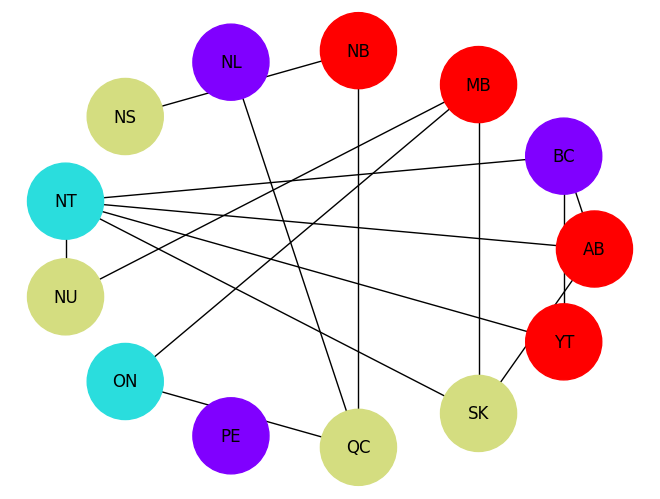

In [10]:
from typing import List
from typing import Tuple
from typing import Dict


def plot_map(sample: Dict[str, bool], provinces: List[str], neighbors: List[Tuple[str]]) -> None:
    G = nx.Graph()
    G.add_nodes_from(provinces)
    G.add_edges_from(neighbors)
    color_map = {}
    for province in provinces:
          for i in range(colors):
            if sample[province+str(i)]:
                color_map[province] = i
    node_colors = [color_map.get(node) for node in G.nodes()]
    nx.draw_circular(G, with_labels=True, node_color=node_colors, node_size=3000, cmap=plt.cm.rainbow)
    plt.show()

plot_map(sample, provinces, neighbors)

После запуска функции `plot_map`, получим изображение графа, в котором вершины будут соответствовать провинциям и цветам, а ребра -- границам между провинциями. Вы можете сами убедиться, что ни одна провинция не будет иметь такой же цвет, как и ее сосед. Также отметим, что такая задача может иметь не одно решение, поэтому не нужно ожидать, что граф будет получаться всегда одним и тем же.

Таким образом, сумели решить задачу раскраски графа с помощью квантового отжигателя.

## Пример: задача электронной структуры молекулы

Поскольку в курсе также имеем дело с задачами квантовой химии, давайте разберем соответствующий пример из {cite}`teplukhin2020electronic`. В данной статье авторы осуществляют точную диагонализацию физического гамильтониана с помощью квантового отжигателя `D-Wave`. Этот подход они называют `QAE` -- `Quantum Annealing Eigensolver`. Разберем эту статью гораздо менее подробно, чем предыдущую задачу.

Основная проблема применения квантового отжига в квантовой химии -- найти отображение гамильтониана электронной структуры молекулы на гамильтониан Изинга (вспомним $\mathcal{H}_{Final}$ из теории квантового отжига, описанной в начале этой лекции). Обычно такие отображения начинаются с записи электронного гамильтониана в [формализме вторичного квантования](https://en.wikipedia.org/wiki/Second_quantization), а затем используют преобразования [Жордана-Вигнера](../../problems2qml/ru/jordanwigner.html#id6) (`Jordan-Wigner transformation`) или Бравого-Китаева (`Bravyi-Kitaev transformation`). Минусы такого подхода заключаются в том, что:

- растет число кубитов, необходимое для описания системы на языке (напомним, классического, а значит -- диагонального) гамильтониана Изинга
- в гамильтониане появляются элементы вне диагонали (благодаря членам содержащим $\sigma^x$, $\sigma^y$).

Подход авторов к задаче состоит из двух частей. Первый шаг состоит из составления электронного гамильтониана в базисе [слетеровских детерминантов](https://en.wikipedia.org/wiki/Slater_determinant), которые в свою очередь составлены из одноэлектронных самосогласованных [орбиталей Хартри-Фока](https://en.wikipedia.org/wiki/Hartree%E2%80%93Fock_method).

В свою очередь, второй этап состоит из нахождения первых нескольких собственных векторов (волновых функций) и собственных значений (соответствующих энергий) этого гамильтониана. Под капотом, задача нахождения собственных значений и собственных векторов отображается на задачу квантового отжига. Это самая хитрая часть алгоритма. Это отображение построено на минимизации отношения Рэлея (`Rayleigh-Ritz quotient`, `RRQ`) $R_{\mathcal{H}}=\langle \psi | \mathcal{H} | \psi \rangle / \langle \psi | \psi \rangle $, где $\mathcal{H}$ -- электронный гамильтониан, а $\psi$ -- волновая функция. Соответствующая минимальному $R$ волновая функция кодируется в бинарный вектор с помощью `power-of-two scheme`. Подробней про это можно почитать в статьях, на которые ссылается оригинальная работа. Примечательно, что метод минимизации отношения Рэлея соответствует вариационному методу в квантовой химии.

На следующей схеме (взята из оригинальной работы) изображен алгоритм `QAE` в общем виде. В нашей терминологии, $A$ соответствует $\mathcal{H}$, $v$ -- $\psi$. $F(v)=\langle v, A v \rangle + \lambda \cdot \langle v, v \rangle $ -- функция потерь в формате `QUBO` -- `Quantum Unconstrained Binary Optimization` (функция потерь на языке `QUBO` получается, если в функции потерь на языке модели Изинга, каждую спиновую переменную $\sigma_i \ \in \ \{-1,1\}$ преобразовать по закону $x_i = (\sigma_i + 1)/2$, $\sigma_i \ \in \ \{0,1\}$), с классическим множителем лагранжа $\lambda$.

```{figure} /_static/dwave/ru/dwave/fig_4.png
:width: 444px

Схема алгоритма `QAE`.
```

```{figure} /_static/dwave/ru/dwave/fig_5.png
:width: 444px

Результаты алгоритма на примере молекулы $H_3^{+}$.
```